# X-Ray Image Classification of Pneumonia in Pediatric Patients

<img src="images/title image.jpeg" style="width: 600px;">

## Overview

This project explores a dataset of x-ray images from pediatric patients with/without pneumonia. The images were selected from cohorts of patients from one to five years old from Guangzhou Women and Children's Medical Center. With the iteration of neural network models, it can help classify whether or not a x-ray image displays pneumonia characters vs. normal.

## Business Understanding



## Data Understanding

In [1]:
#downloading the data from kaggle
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download")

     |████████████████████████████████| 58 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 9.8 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=19fb64eae0c26c3d995de1de78826e81615c3f06f4e27460e919597cb4cc9f26
  Stored in directory: /Users/toscale/Library/Caches/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: toscale
Your Kaggle Key: ········


  0%|          | 0.00/2.29G [00:00<?, ?B/s]

100%|██████████| 2.29G/2.29G [02:48<00:00, 14.6MB/s]


In [48]:
#imports
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os

import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2

In [2]:
data_path = './chest-xray-pneumonia/chest_xray'
train_path = data_path + '/train/'
test_path = data_path + '/test/'
val_path = data_path + '/val/'

In [3]:
#reshaping the images, and read in data from folders (https://www.kaggle.com/jedrzejdudzicz/pneumonia-detection-on-chest-x-ray-accuracy-92?scriptVersionId=42312416&cellId=15)
img_size = 200


def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image = cv2.resize(cv2.imread(image_path),
                                       (img_size, img_size))
                    if image is not None:
                        images.append([image, label])

    images = np.asarray(images)
    return images

In [4]:
train = read_data([train_path])
test = read_data([test_path])
val = read_data([val_path])

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


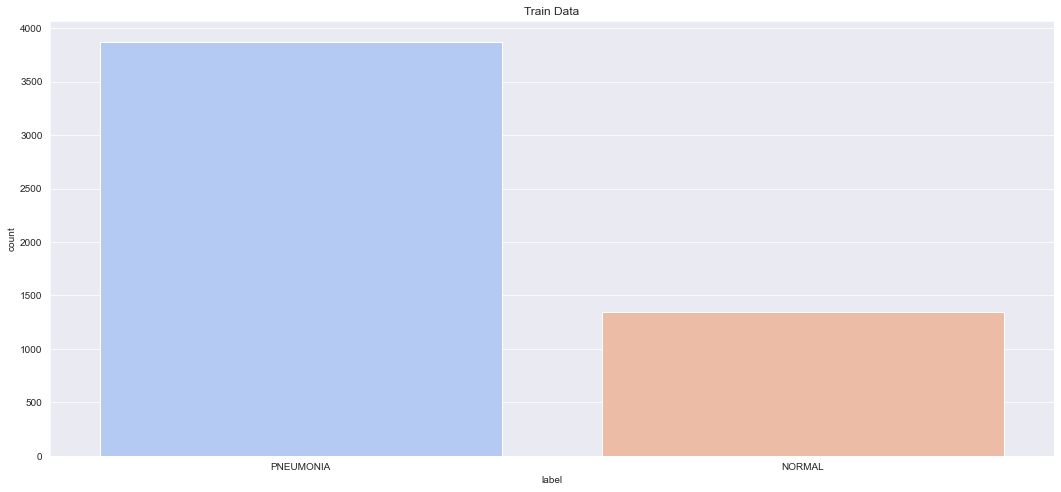

In [6]:
#visualizing the train dataset, first creating a dataframe
train_df = pd.DataFrame(train, columns=['image', 'label'])

plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train Data')

plt.show()

The training data seems imbalanced. 

## Data Preparation

In [22]:
#now splitting data into X_train, y_train, etc.
X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

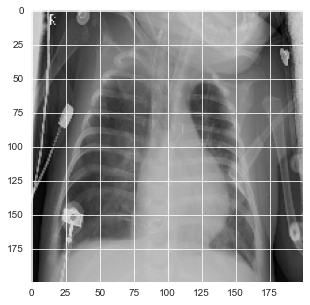

In [15]:
#visualize examples from the train dataset #need to add label
plt.figure(figsize=(5, 5))
plt.imshow(train[0][0])

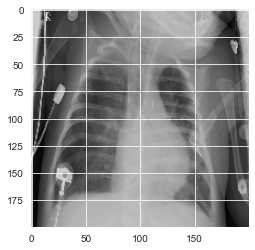

In [25]:
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.show()

In [24]:
#checking the shape/format of our input
X_train

[array([[[205, 205, 205],
         [206, 206, 206],
         [205, 205, 205],
         ...,
         [196, 196, 196],
         [204, 204, 204],
         [213, 213, 213]],
 
        [[204, 204, 204],
         [204, 204, 204],
         [204, 204, 204],
         ...,
         [197, 197, 197],
         [211, 211, 211],
         [208, 208, 208]],
 
        [[204, 204, 204],
         [204, 204, 204],
         [204, 204, 204],
         ...,
         [197, 197, 197],
         [208, 208, 208],
         [213, 213, 213]],
 
        ...,
 
        [[ 18,  18,  18],
         [ 13,  13,  13],
         [ 11,  11,  11],
         ...,
         [ 47,  47,  47],
         [ 49,  49,  49],
         [ 51,  51,  51]],
 
        [[ 14,  14,  14],
         [ 14,  14,  14],
         [ 11,  11,  11],
         ...,
         [ 47,  47,  47],
         [ 48,  48,  48],
         [ 49,  49,  49]],
 
        [[ 14,  14,  14],
         [ 13,  13,  13],
         [ 11,  11,  11],
         ...,
         [ 45,  45,  45],
  

In [29]:
#since this is currently a list, change to arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [31]:
print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

Train Shape: (5216, 200, 200, 3)
Test Shape: (624, 200, 200, 3)


In [33]:
#since these images are x-rays, they are a little more complex than simple images which is better suited for MLP
#cnn is probably better suited after a baseline model
#cnn takes 4-D tensors as input, which is what we have
#first, must normalize image data (since all pixel values will always be between 0 and 255)
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [36]:
#data augmentation, applies random transformations on each image as it is passed to the model
#makes model more robust and saves on memory
#also prevents overfitting and handling imbalance in dataset
datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)
datagen.fit(X_train)

## Modeling

### Baseline Model

In [38]:
#baseline model (helpful code from Joél study group)
def baseline_model(image):
    layers= [Input(image.shape),
            Flatten(),
            Dense(100, activation = 'relu'),
            Dense(10, activation = 'sigmoid'),
            ]
    model = Sequential(layers)
    model.compile(loss='binary_crossentropy',
                 optimizer='adam', #gradient descent, moving average
                 metrics=['accuracy'])
    return model

In [39]:
#initialize the model and pass in 1 of the train images to set the shape of input images
model_1 = baseline_model(X_train[0])

In [40]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120000)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               12000100  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 12,001,110
Trainable params: 12,001,110
Non-trainable params: 0
_________________________________________________________________


In [47]:
#fit the model
base = model_1.fit(datagen.flow(X_train, y_train, batch_size=32),
                   epochs=10,
                   validation_)

Epoch 1/10


ValueError: in user code:

    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/ops/nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 10) vs (None, 1))


### Basic Convolutional Neural Network (CNN) Model